In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('default')

# 모든 열 보기
pd.set_option('display.max_columns', None)

print("=" * 80)
print("제약 제조 데이터 전처리 및 특성 엔지니어링 실습")
print("=" * 80)

제약 제조 데이터 전처리 및 특성 엔지니어링 실습


## 1. 데이터 수집 및 로딩

In [195]:
 # 실험실 데이터 (배치별 원료, 중간제품, 완제품 품질 데이터)
laboratory_df = pd.read_csv('./data/Laboratory.csv', sep=';')
print(f"✅ Laboratory 데이터 로딩 완료: {laboratory_df.shape}")

# 공정 데이터 (배치별 집계된 공정 센서 데이터)
process_df = pd.read_csv('./data/Process.csv', sep=';')
print(f"✅ Process 데이터 로딩 완료: {process_df.shape}")

# 정규화 계수 데이터
normalization_df = pd.read_csv('./data/Normalization.csv', sep=';')
print(f"✅ Normalization 데이터 로딩 완료: {normalization_df.shape}")

process_time_series_df = pd.read_csv('./data/Process/1.csv', sep=';')
print(f"✅ Process_time-series 데이터 로딩 완료: {process_time_series_df.shape}")


print(f"\n📈 데이터 개요:")
print(f"- 총 배치 수: {len(laboratory_df)}")
print(f"- Laboratory 변수 수: {len(laboratory_df.columns)}")
print(f"- Process 변수 수: {len(process_df.columns)}")

✅ Laboratory 데이터 로딩 완료: (1005, 55)
✅ Process 데이터 로딩 완료: (1005, 35)
✅ Normalization 데이터 로딩 완료: (25, 3)
✅ Process_time-series 데이터 로딩 완료: (106878, 16)

📈 데이터 개요:
- 총 배치 수: 1005
- Laboratory 변수 수: 55
- Process 변수 수: 35


## **1. Laboratory.csv (총 55 개 컬럼)**

|**구분**|**컬럼**|**의미**|
|---|---|---|
|**계보 정보**|batch|최종 제품 배치 번호(인덱스)|
||code|제품 하위군(sub-family)을 구분하는 제품 코드|
||strength|정제 1 개당 API 함량 (mg)|
||size|목표 생산 정제 수(배치 크기)|
||start|생산 시작 시각(YYYY-MM-DD hh:mm)|
|**API/부형제 계열**|api_code, api_batch|API 자재 코드·배치 번호|
||smcc_batch, lactose_batch, starch_batch|실리카화 MCC, 락토스, 전분 배치 번호|
|**API 품질**|api_water|API 수분 함량(%)|
||api_total_impurities, api_l_impurity|총 불순물·L-불순물 함량(%)|
||api_content|순 API 함량(%)|
||api_ps01, api_ps05, api_ps09|입도 10 %·50 %·90 %(µm)|
|**락토스 품질**|lactose_water|수분(%)|
||lactose_sieve0045, …015, …025|체별 잔류율(%)|
|**SMCC 품질**|smcc_water|수분(%)|
||smcc_td, smcc_bd|탭 밀도·벌크 밀도(g/ml)|
||smcc_ps01, smcc_ps05, smcc_ps09|입도 10 / 50 / 90 %(µm)|
|**전분 품질**|starch_ph|pH|
||starch_water|수분(%)|
|**중간제품(정제심) 품질**|tbl_min_thickness, tbl_max_thickness|정제심 최소·최대 두께(mm)|
||tbl_min_weight, tbl_max_weight|정제심 최소·최대 중량(mg)|
||tbl_rsd_weight|정제심 중량 RSD(%)|
||tbl_min_hardness, tbl_max_hardness, tbl_av_hardness|정제심 경도 최소·최대·평균(N)|
|**코팅 후 품질**|fct_min_thickness, fct_max_thickness|코팅정 최소·최대 두께(mm)|
||fct_rsd_weight|코팅정 중량 RSD(%)|
||fct_min_hardness, fct_max_hardness, fct_av_hardness|코팅정 경도 최소·최대·평균(N)|
|**가공 지표**|tbl_tensile, fct_tensile|정제심·코팅정 인장강도(정규화 경도)|
||tbl_yield, batch_yield|압축 공정·전체 배치 수율(%)|
|**최종제품 품질**|dissolution_av, dissolution_min|30 분 약물 방출 평균·최소값(%)|
||residual_solvent|잔류 용매(%)|
||impurities_total, impurity_o, impurity_l|총 불순물, O / L 불순물(%)|

---

## **2. Process Time-series 파일(예: 1.csv)**

|**컬럼**|**의미**|**주요 단위**|
|---|---|---|
|timestamp|10 초 간격 타임스탬프(인덱스)|–|
|campaign|동일 설비 주기 내 배치 묶음 번호|–|
|batch, code|최종제품 배치·제품 코드|–|
|tbl_speed|타정기 프레스 속도(정제/h)|tablets/hour|
|fom|충전 장치 회전 속도|rpm|
|main_comp|메인 압축력 평균|kN|
|tbl_fill|충전 깊이(정제심 체적)|mm|
|SREL|메인 압축력 상대표준편차|%|
|pre_comp|프리-압축력 평균|kN|
|produced|누적 양품 정제수|tablets|
|waste|누적 불량 정제수|tablets|
|cyl_main, cyl_pre|메인·프리 실린드리컬 높이|mm|
|stiffness|하부 펀치 강성|N|
|ejection|정제 배출력 최대값|N|

---

## **3. Process.csv (배치당 파생 특성)**

|**컬럼**|**의미**||
|---|---|---|
|tbl_speed_mean|0 값 제외 평균 프레스 속도||
|tbl_speed_change|속도 변동 횟수(배치 크기로 정규화)||
|tbl_speed_0_duration|속도 0 인 누적 시간(정규화, 주말 제외)||
|total_waste, startup_waste|배치 전체·시동 구간 불량 수(정규화)||
|weekend|주말 생산 여부(Yes/No)||
|fom_mean, fom_change|충전 속도 평균·변동 횟수||
|SREL_startup_mean, SREL_production_mean, SREL_production_max|SREL 시동 평균, 생산 평균·최대||
|main_CompForce_mean, …_sd, …_median|메인 압축력 평균·표준편차·중앙값||
|pre_CompForce_mean|프리 압축력 평균||
|tbl_fill_mean, tbl_fill_sd|충전 깊이 평균·표준편차||
|cyl_height_mean|실린더 높이 평균||
|stiffness_mean/max/min|하부 펀치 강성 평균·최대·최소||
|ejection_mean/max/min|배출력 평균·최대·최소||
|Startup_tbl_fill_maxDifference|시동 구간 충전 깊이 최대-최소 차||
|Startup_main_CompForce_mean, Startup_tbl_fill_mean|시동 구간 메인 압축력·충전 깊이 평균||

---

## **4. Normalization.csv**

|**컬럼**|**의미**|
|---|---|
|Product code|제품 코드(하위군)|
|Batch Size (tablets)|해당 하위군 목표 배치 크기(정제 수)|
|Normalisation factor|배치 크기에 따라 계산된 정규화 계수 (예: Batch Size ÷ 100 000) — 파생 특성 값을 배치 크기로 보정할 때 사용|


In [196]:
laboratory_df

,batch,code,strength,size,start,api_code,api_batch,smcc_batch,lactose_batch,starch_batch,api_water,api_total_impurities,api_l_impurity,api_content,api_ps01,api_ps05,api_ps09,lactose_water,lactose_sieve0045,lactose_sieve015,lactose_sieve025,smcc_water,smcc_td,smcc_bd,smcc_ps01,smcc_ps05,smcc_ps09,starch_ph,starch_water,tbl_min_thickness,tbl_max_thickness,fct_min_thickness,fct_max_thickness,tbl_min_weight,tbl_max_weight,tbl_rsd_weight,fct_rsd_weight,tbl_min_hardness,tbl_max_hardness,tbl_av_hardness,fct_min_hardness,fct_max_hardness,fct_av_hardness,tbl_max_diameter,fct_max_diameter,tbl_tensile,fct_tensile,tbl_yield,batch_yield,dissolution_av,dissolution_min,resodual_solvent,impurities_total,impurity_o,impurity_l
0,1,25,5MG,240000,nov.18,5,2,1,2,1,1.53,0.25,0.13,94.5,1.27,18.52,109.999,0.05,17,50,82,4.251,0.45,0.33,31.156,112.141,245.499,4.4,3.012,3.3,3.4,3.4,3.4,111.0,116.0,0.92,0.72,56.84,68.60,46,37.00,56.00,62.72,6.1,6.1,1.412698,1.926183,95.785,94.697,93.83,86,0.06,0.33,0.05,0.16
1,2,25,5MG,240000,nov.18,5,2,1,2,1,1.53,0.25,0.13,94.5,1.27,18.52,109.999,0.05,17,50,82,4.251,0.45,0.33,31.156,112.141,245.499,4.4,3.012,3.3,3.4,3.4,3.4,112.0,116.0,0.89,0.80,56.84,70.56,46,39.00,56.00,64.68,6.1,6.1,1.412698,1.986377,98.467,97.348,99.67,92,0.04,0.34,0.06,0.16
2,3,25,5MG,240000,nov.18,5,2,1,2,1,1.53,0.25,0.13,94.5,1.27,18.52,109.999,0.05,17,50,82,4.251,0.45,0.33,31.156,112.141,245.499,4.4,3.012,3.3,3.4,3.4,3.4,111.0,115.0,0.83,0.78,58.80,70.56,46,39.00,57.00,65.66,6.1,6.1,1.412698,2.016473,98.496,99.242,97.33,92,0.03,0.28,0.05,0.16
3,4,25,5MG,240000,nov.18,5,2,1,2,1,1.53,0.25,0.13,94.5,1.27,18.52,109.999,0.05,17,50,82,4.251,0.45,0.33,31.156,112.141,245.499,4.4,3.012,3.3,3.4,3.4,3.4,110.0,117.0,0.53,0.88,58.80,72.52,48,57.00,40.00,63.70,6.1,6.1,1.474120,1.956280,97.736,98.106,94.50,89,0.03,0.30,0.05,0.18
4,5,25,5MG,240000,nov.18,5,2,1,2,1,1.53,0.25,0.13,94.5,1.27,18.52,109.999,0.05,17,50,82,4.251,0.45,0.33,31.156,112.141,245.499,4.4,3.012,3.3,3.4,3.4,3.4,112.0,115.0,0.75,0.69,56.84,68.60,47,39.00,59.00,62.72,6.1,6.1,1.443409,1.926183,98.106,98.106,92.00,88,0.04,0.31,0.05,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,1001,17,20M,960000,apr.21,3,254,18,22,17,1.5,0.32,...,94.4,3,36,145,0.08,17,50,82,4.445,0.45,0.33,30.363,119.557,262.707,4.5,2.463,4.1,4.1,4.1,4.2,222.0,234.0,1.31,1.87,35.00,61.00,47,48.02,75.46,58.80,8.1,8.1,0.901424,1.100889,98.623,98.343,91.00,85,0.02,0.05,0.05,0.05
1001,1002,17,20M,960000,apr.21,3,254,18,22,17,1.5,0.32,...,94.4,3,36,145,0.08,17,50,82,4.445,0.45,0.33,30.363,119.557,262.707,4.5,2.463,4.0,4.1,4.1,4.2,219.0,227.0,1.25,0.97,38.00,70.00,49,46.06,68.60,56.84,8.1,8.1,0.939783,1.064192,98.626,98.532,89.17,84,0.02,0.05,0.05,0.05
1002,1003,17,20M,960000,apr.21,3,254,18,22,17,1.5,0.32,...,94.4,3,36,145,0.08,17,50,82,4.445,0.45,0.33,30.363,119.557,262.707,4.5,2.463,4.0,4.1,4.1,4.1,221.0,228.0,1.11,0.81,38.00,63.00,49,49.98,69.58,57.82,8.1,8.1,0.939783,1.108944,98.157,98.343,90.83,87,0.02,0.05,0.05,0.05
1003,1004,17,20M,960000,apr.21,3,254,18,22,17,1.5,0.32,...,94.4,3,36,145,0.08,17,50,82,4.445,0.45,0.33,30.363,119.557,262.707,4.5,2.463,4.0,4.1,4.1,4.1,221.0,228.0,1.02,0.99,38.00,68.00,54,56.84,72.52,64.68,8.1,8.2,1.035679,1.225385,99.336,99.242,92.67,90,0.02,0.05,0.05,0.05


In [197]:
process_df

,batch,code,tbl_speed_mean,tbl_speed_change,tbl_speed_0_duration,total_waste,startup_waste,weekend,fom_mean,fom_change,SREL_startup_mean,SREL_production_mean,SREL_production_max,main_CompForce mean,main_CompForce_sd,main_CompForce_median,pre_CompForce_mean,tbl_fill_mean,tbl_fill_sd,cyl_height_mean,stiffness_mean,stiffness_max,stiffness_min,ejection_mean,ejection_max,ejection_min,Startup_tbl_fill_maxDifference,Startup_main_CompForce_mean,Startup_tbl_fill_mean,Drug release average (%),Drug release min (%),Residual solvent,Total impurities,Impurity O,Impurity L
0,1,25,99.864656,5.416667,149.583333,2125.416667,5085,no,49.961446,12,4.392000,3.559876,7.1,4.255404,0.058473,4.3,0.100000,5.332248,0.095938,2.099466,91.016149,103,67,223.319255,248,196,0.38,4.587500,5.466667,93.83,86.0,0.06,0.33,0.05,0.16
1,2,25,99.936342,2.500000,128.333333,887.500000,2115,no,49.962040,5,9.258333,3.494946,8.8,4.251023,0.056788,4.2,0.099278,5.299531,0.099699,2.105271,88.223827,103,77,215.963899,252,194,0.18,4.390909,5.315455,99.67,92.0,0.04,0.34,0.06,0.16
2,3,25,99.985984,2.500000,83.333333,796.250000,1895,no,49.961176,6,7.200000,3.392133,8.7,4.261263,0.054522,4.3,0.004768,5.311097,0.107814,2.113004,88.967819,111,72,212.530393,248,184,0.12,4.430000,5.242000,97.33,92.0,0.03,0.28,0.05,0.16
3,4,25,99.976868,2.916667,76.250000,695.833333,1645,no,49.960900,9,7.122222,3.416048,9.0,4.357605,0.062705,4.4,0.000000,5.309988,0.115554,2.104527,101.431138,121,83,225.938922,262,197,0.24,4.500000,5.221250,94.50,89.0,0.03,0.30,0.05,0.18
4,5,25,99.968284,2.500000,121.250000,829.166667,1971,no,50.000000,5,14.450000,3.460359,9.8,4.249461,0.056975,4.2,0.000000,5.319629,0.103194,2.126347,108.978443,132,91,237.305389,264,205,0.19,3.960000,5.233000,92.00,88.0,0.04,0.31,0.05,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,1001,17,119.973595,1.458333,43.125000,972.395833,3564,no,79.955846,8,9.192857,6.069116,8.1,6.245474,0.083523,6.2,0.000000,6.736649,0.055184,1.819130,44.031594,56,7,192.169329,212,138,0.20,6.333333,6.523333,NaN,NaN,NaN,NaN,NaN,NaN
1001,1002,17,119.941321,2.604167,43.125000,1055.625000,4090,no,80.000000,8,5.943750,5.409258,7.4,6.149187,0.089366,6.1,0.000000,6.718435,0.099598,1.825717,42.977385,57,6,194.642756,219,137,0.13,5.987500,6.438125,NaN,NaN,NaN,NaN,NaN,NaN
1002,1003,17,119.893113,3.958333,42.812500,1456.875000,6950,no,79.978230,9,6.000000,5.131303,7.0,6.349876,0.097192,6.3,0.000000,6.738101,0.067520,1.815551,47.306766,57,7,204.655685,243,120,0.38,6.134783,6.381739,NaN,NaN,NaN,NaN,NaN,NaN
1003,1004,17,120.000000,1.145833,36.041667,404.687500,1793,no,79.964059,9,9.970000,4.698833,7.4,6.557320,0.088333,6.6,0.000000,6.657546,0.064084,1.780000,44.155233,56,7,210.176096,238,187,0.22,5.887500,6.532500,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
normalization_df

,Product code,Batch Size (tablets),Normalisation factor
0,1,240000,2.40
1,2,1920000,19.20
2,3,960000,9.60
3,4,583000,5.83
4,5,2400000,24.00
5,6,2400000,24.00
6,7,1200000,12.00
7,8,1100000,11.00
8,9,240000,2.40
9,10,960000,9.60


In [199]:
process_time_series_df
# tbl_speed가 0인 경우 해당 시간에 공정이 중단된 것으로 판단

,timestamp,campaign,batch,code,tbl_speed,fom,main_comp,tbl_fill,SREL,pre_comp,produced,waste,cyl_main,cyl_pre,stiffness,ejection
0,2018-11-22 23:07:27,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
1,2018-11-22 23:07:37,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
2,2018-11-22 23:07:47,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
3,2018-11-22 23:07:57,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
4,2018-11-22 23:08:07,4,26,1,0.0,0.0,0.2,4.09,0.0,0.0,0.0,0.0,1.06,4.0,3.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106873,2019-10-25 13:43:32,109,453,1,0.0,0.0,4.5,5.51,5.4,0.3,235.0,1426.0,1.95,3.0,99.0,164.0
106874,2019-10-25 13:43:42,109,453,1,0.0,0.0,4.5,5.51,5.4,0.3,235.0,1426.0,1.95,3.0,99.0,164.0
106875,2019-10-25 13:43:52,109,453,1,0.0,0.0,4.5,5.51,5.4,0.3,235.0,1426.0,1.95,3.0,99.0,164.0
106876,2019-10-25 13:44:02,109,453,1,0.0,0.0,4.5,5.51,5.4,0.3,235.0,1426.0,1.95,3.0,99.0,164.0


## 2. 데이터 통계 및 결측치 확인

### 2-1. 결측치 확인

In [200]:
print("🔍 Laboratory 데이터 기본 정보:")
print(laboratory_df.info())

print("\n🔍 Process 데이터 기본 정보:")
print(process_df.info())

🔍 Laboratory 데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   batch                 1005 non-null   int64  
 1   code                  1005 non-null   int64  
 2   strength              1005 non-null   object 
 3   size                  1005 non-null   int64  
 4   start                 1005 non-null   object 
 5   api_code              1005 non-null   int64  
 6   api_batch             1005 non-null   int64  
 7   smcc_batch            1005 non-null   int64  
 8   lactose_batch         1005 non-null   int64  
 9   starch_batch          1005 non-null   int64  
 10  api_water             1005 non-null   object 
 11  api_total_impurities  1000 non-null   object 
 12  api_l_impurity        996 non-null    object 
 13  api_content           1003 non-null   float64
 14  api_ps01              1005 non-null   object 
 1

In [201]:
# Laboratory 데이터에서 결측값이 있는 행 확인
print("🔍 Laboratory 데이터에서 결측값이 있는 행:")
null_rows = laboratory_df[laboratory_df.isnull().any(axis=1)]
print(f"총 {len(null_rows)}개 행에 결측값 존재")
# 특정 컬럼만 출력
columns_to_show = ['api_total_impurities', 'api_l_impurity', 'api_content', 'tbl_min_weight', 'tbl_max_weight']
null_rows[columns_to_show]


🔍 Laboratory 데이터에서 결측값이 있는 행:
총 21개 행에 결측값 존재


,api_total_impurities,api_l_impurity,api_content,tbl_min_weight,tbl_max_weight
187,0.5,NaN,93.8,112.0,116.0
251,0.23,NaN,94.8,112.0,116.0
252,0.23,NaN,94.8,112.0,115.0
253,0.23,NaN,94.8,112.0,115.0
453,0.08,0,94.5,NaN,NaN
471,0.08,0,94.5,NaN,NaN
536,0.38,,94.3,NaN,NaN
537,0.38,,94.3,NaN,NaN
538,0.38,,94.3,NaN,NaN
539,0.38,,94.3,NaN,NaN


### 2-2. 공백 값 확인 및 결측 값으로 변환
- api_l_impurity 컬럼에 공백이 있는것을 확인
- 공백이 있는 컬럼을 모두 확인

In [202]:
# 공백값이 있는 행들을 먼저 확인
print("🔍 공백값이 있는 행들:")
# 공백 패턴을 찾기 위해 문자열 컬럼들을 확인
string_columns = laboratory_df.select_dtypes(include=['object']).columns
print(f"문자열 타입 컬럼들: {list(string_columns)}")

# 각 문자열 컬럼에서 공백 패턴 확인
for col in string_columns:
    blank_mask = laboratory_df[col].astype(str).str.match(r'^\s*$')
    blank_count = blank_mask.sum()
    if blank_count > 0:
        print(f"\n컬럼 '{col}'에서 공백값 {blank_count}개 발견:")

🔍 공백값이 있는 행들:
문자열 타입 컬럼들: ['strength', 'start', 'api_water', 'api_total_impurities', 'api_l_impurity', 'api_ps01', 'api_ps05', 'api_ps09']

컬럼 'api_water'에서 공백값 26개 발견:

컬럼 'api_total_impurities'에서 공백값 62개 발견:

컬럼 'api_l_impurity'에서 공백값 361개 발견:

컬럼 'api_ps01'에서 공백값 26개 발견:

컬럼 'api_ps05'에서 공백값 26개 발견:

컬럼 'api_ps09'에서 공백값 26개 발견:


In [203]:
# Laboratory 데이터에서 공백값을 NaN으로 변경 (dropna 시 공백 행이 남아있는 것을 방지)
laboratory_df = laboratory_df.replace(r'^\s*$', np.nan, regex=True)
# Laboratory 데이터에서 결측값이 있는 행 확인
print("🔍 Laboratory 데이터에서 결측값이 있는 행:")
null_rows = laboratory_df[laboratory_df.isnull().any(axis=1)]
print(f"총 {len(null_rows)}개 행에 결측값 존재")
# 특정 컬럼만 출력
columns_to_show = ['api_total_impurities', 'api_l_impurity', 'api_content', 'tbl_min_weight', 'tbl_max_weight']
null_rows[columns_to_show]

🔍 Laboratory 데이터에서 결측값이 있는 행:
총 374개 행에 결측값 존재


,api_total_impurities,api_l_impurity,api_content,tbl_min_weight,tbl_max_weight
87,0.33,NaN,93.7,111.0,116.0
88,0.39,NaN,93.7,109.0,114.0
187,0.5,NaN,93.8,112.0,116.0
225,0.38,NaN,93.5,221.0,229.0
226,0.38,NaN,94.1,221.0,229.0
...,...,...,...,...,...
1000,0.32,NaN,94.4,222.0,234.0
1001,0.32,NaN,94.4,219.0,227.0
1002,0.32,NaN,94.4,221.0,228.0
1003,0.32,NaN,94.4,221.0,228.0


In [204]:
# Process 데이터에서 결측값이 있는 행 확인
print("🔍 Process 데이터에서 결측값이 있는 행:")
null_rows = process_df[process_df.isnull().any(axis=1)]
print(f"총 {len(null_rows)}개 행에 결측값 존재")
# 특정 컬럼만 출력
columns_to_show = ['Drug release average (%)', 'Drug release min (%)', 'Residual solvent', 'Total impurities', 'Impurity O', 'Impurity L']
null_rows[columns_to_show]


🔍 Process 데이터에서 결측값이 있는 행:
총 18개 행에 결측값 존재


,Drug release average (%),Drug release min (%),Residual solvent,Total impurities,Impurity O,Impurity L
987,NaN,NaN,NaN,NaN,NaN,NaN
988,NaN,NaN,NaN,NaN,NaN,NaN
989,NaN,NaN,NaN,NaN,NaN,NaN
990,NaN,NaN,NaN,NaN,NaN,NaN
991,NaN,NaN,NaN,NaN,NaN,NaN
992,NaN,NaN,NaN,NaN,NaN,NaN
993,NaN,NaN,NaN,NaN,NaN,NaN
994,NaN,NaN,NaN,NaN,NaN,NaN
995,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN


### 2-3. 결측치 확인

#### Laboratory 데이터
- **dissolution_av, dissolution_min**: 용해도 관련 품질 지표
- **impurities_total, impurity_o, impurity_l**: 불순물 함량 지표
- 총 21개 배치에서 결측값 발생

#### Process 데이터  
- **tbl_speed_mean, tbl_speed_change**: 타정기 속도 관련 지표
- **total_waste, startup_waste**: 불량품 수량 지표
- **fom_mean, fom_change**: 충전 장치 속도 관련 지표
- 총 121개 배치에서 결측값 발생

### 📋 결측치 처리 방법

#### 1. 중앙값(Median) 대체 방법 선택 이유
- **로버스트성**: 이상값에 영향을 받지 않음
- **제조 공정 특성**: 품질 관리 기준값 근처에 데이터가 집중되는 경향
- **분포 보존**: 원본 데이터의 분포 특성을 유지

#### 2. 처리 방법별 비교
# 
# | 방법 | 장점 | 단점 |
# |------|------|------|
# | **중앙값 대체** | 이상값에 강건, 분포 보존 | 변동성 감소 |
# | 평균값 대체 | 계산 간단 | 이상값에 민감 |
# | 삭제 | 데이터 순수성 유지 | 정보 손실 |
# | 보간법 | 시계열 특성 반영 | 복잡성 증가 |
#### 3. 제조업 특성 고려사항
- **품질 관리**: 규격 범위 내 값으로 대체 필요
- **공정 연속성**: 배치 간 연관성 고려
- **안전성**: 보수적 접근으로 중앙값 선택

#### 4. 검증 방법
- 대체 전후 분포 비교
- 주요 통계량 변화 확인
- 품질 지표 상관관계 유지 검증


In [205]:
# 결측치 처리 전 데이터 분포 확인
print("📊 결측치 처리 전 데이터 분포 분석")
print("="*50)

# Laboratory 데이터 결측치 현황
print("\n🧪 Laboratory 데이터 결측치 현황:")
lab_missing = laboratory_df.isnull().sum()
lab_missing_cols = lab_missing[lab_missing > 0]
for col, count in lab_missing_cols.items():
    print(f"   - {col}: {count}개 ({count/len(laboratory_df)*100:.1f}%)")

# Process 데이터 결측치 현황  
print("\n⚙️ Process 데이터 결측치 현황:")
process_missing = process_df.isnull().sum()
process_missing_cols = process_missing[process_missing > 0]
for col, count in process_missing_cols.items():
    print(f"   - {col}: {count}개 ({count/len(process_df)*100:.1f}%)")

📊 결측치 처리 전 데이터 분포 분석

🧪 Laboratory 데이터 결측치 현황:
   - api_water: 26개 (2.6%)
   - api_total_impurities: 67개 (6.7%)
   - api_l_impurity: 370개 (36.8%)
   - api_content: 2개 (0.2%)
   - api_ps01: 26개 (2.6%)
   - api_ps05: 26개 (2.6%)
   - api_ps09: 26개 (2.6%)
   - tbl_min_weight: 10개 (1.0%)
   - tbl_max_weight: 10개 (1.0%)

⚙️ Process 데이터 결측치 현황:
   - Drug release average (%): 18개 (1.8%)
   - Drug release min (%): 18개 (1.8%)
   - Residual solvent: 18개 (1.8%)
   - Total impurities: 18개 (1.8%)
   - Impurity O: 18개 (1.8%)
   - Impurity L: 18개 (1.8%)


#### 왜도를 계산하여 결측치 처리 방법 선택
💡 결측치 처리 방법 결정:
   - 왜도가 0.5 미만인 컬럼: 평균값 대체
   - 왜도가 0.5 이상인 컬럼: 중앙값 대체 (이상값에 강건)

In [206]:
# Laboratory 데이터 결측치 컬럼 분포 분석
lab_missing_analysis_cols = ['api_l_impurity', 'api_total_impurities', 'api_content', 'tbl_min_weight', 'tbl_max_weight']
for col in lab_missing_analysis_cols:
    if col in laboratory_df.columns:
        # 결측값과 공백만 있는 문자열 제거하고 float 타입으로 변환
        data = pd.to_numeric(laboratory_df[col], errors='coerce').dropna()
        if len(data) > 0:
            # 왜도(Skewness) 계산: 데이터 분포의 비대칭성을 측정하는 통계량
            skewness = data.skew()
            print(f"   🧪 {col}:")
            print(f"      - 평균: {data.mean():.3f}, 중앙값: {data.median():.3f}")
            print(f"      - 왜도: {skewness:.3f} ({'정규분포에 가까움' if abs(skewness) < 0.5 else '치우침 있음'})")

   🧪 api_l_impurity:
      - 평균: 0.061, 중앙값: 0.060
      - 왜도: -0.499 (정규분포에 가까움)
   🧪 api_total_impurities:
      - 평균: 0.231, 중앙값: 0.210
      - 왜도: -0.002 (정규분포에 가까움)
   🧪 api_content:
      - 평균: 94.418, 중앙값: 94.400
      - 왜도: 0.323 (정규분포에 가까움)
   🧪 tbl_min_weight:
      - 평균: 191.015, 중앙값: 219.000
      - 왜도: 1.299 (치우침 있음)
   🧪 tbl_max_weight:
      - 평균: 198.297, 중앙값: 228.000
      - 왜도: 1.294 (치우침 있음)


In [207]:
# Process 데이터 결측치 컬럼 분포 분석
process_missing_analysis_cols = ['Drug release average (%)', 'Drug release min (%)', 'Residual solvent', 'Total impurities', 'Impurity O', 'Impurity L']
for col in process_missing_analysis_cols:
    if col in process_df.columns:
        data = process_df[col].dropna()
        if len(data) > 0:
            skewness = data.skew()
            print(f"   ⚙️ {col}:")
            print(f"      - 평균: {data.mean():.3f}, 중앙값: {data.median():.3f}")
            print(f"      - 왜도: {skewness:.3f} ({'정규분포에 가까움' if abs(skewness) < 0.5 else '치우침 있음'})")


   ⚙️ Drug release average (%):
      - 평균: 90.668, 중앙값: 90.330
      - 왜도: 0.372 (정규분포에 가까움)
   ⚙️ Drug release min (%):
      - 평균: 85.611, 중앙값: 85.000
      - 왜도: 0.286 (정규분포에 가까움)
   ⚙️ Residual solvent:
      - 평균: 0.048, 중앙값: 0.040
      - 왜도: 1.479 (치우침 있음)
   ⚙️ Total impurities:
      - 평균: 0.141, 중앙값: 0.090
      - 왜도: 0.686 (치우침 있음)
   ⚙️ Impurity O:
      - 평균: 0.053, 중앙값: 0.050
      - 왜도: 4.123 (치우침 있음)
   ⚙️ Impurity L:
      - 평균: 0.073, 중앙값: 0.050
      - 왜도: 1.237 (치우침 있음)


### 2-4. 결측값 처리

In [208]:
# 데이터 복사 - 원본 데이터 보호를 위한 깊은 복사(Deep Copy) 수행
# 🔒 원본 데이터 보호: 전처리 과정에서 원본 데이터가 변경되는 것을 방지
# 📊 메모리 독립성: 새로운 메모리 공간에 데이터를 복사하여 독립적인 객체 생성
# 🔄 되돌리기 가능: 전처리 실패 시 원본 데이터로 쉽게 복원 가능
# ⚡ 안전한 실험: 다양한 전처리 방법을 안전하게 테스트할 수 있음
lab_clean = laboratory_df.copy()
process_clean = process_df.copy()

In [209]:
lab_missing_analysis_cols
process_missing_analysis_cols

['Drug release average (%)',
 'Drug release min (%)',
 'Residual solvent',
 'Total impurities',
 'Impurity O',
 'Impurity L']

In [210]:
# 결측값을 평균값으로 대체 (정규분포에 가까운 경우) 또는 중앙값으로 대체 (치우침이 있는 경우)
for col in lab_missing_analysis_cols:
    if lab_clean[col].isnull().sum() > 0:
        missing_count = lab_clean[col].isnull().sum()
        
        # 숫자형 데이터로 변환 후 결측값 제거하여 통계량 계산
        numeric_data = pd.to_numeric(lab_clean[col], errors='coerce').dropna()
        
        if len(numeric_data) > 0:
            # 왜도를 계산하여 평균값 또는 중앙값 선택
            skewness = numeric_data.skew()
            if abs(skewness) < 0.5:  # 정규분포에 가까운 경우
                fill_value = numeric_data.mean()
                fill_method = "평균값"
            else:  # 치우침이 있는 경우
                fill_value = numeric_data.median()
                fill_method = "중앙값"
                
            lab_clean[col].fillna(fill_value, inplace=True)
            print(f"   - {col}: 결측값 {missing_count}개를 [{fill_method}] {fill_value:.2f}로 대체")

for col in process_missing_analysis_cols:
    if process_clean[col].isnull().sum() > 0:
        missing_count = process_clean[col].isnull().sum()
        
        # 숫자형 데이터로 변환 후 결측값 제거하여 통계량 계산
        numeric_data = pd.to_numeric(process_clean[col], errors='coerce').dropna()
        
        if len(numeric_data) > 0:
            # 왜도를 계산하여 평균값 또는 중앙값 선택
            skewness = numeric_data.skew()
            if abs(skewness) < 0.5:  # 정규분포에 가까운 경우
                fill_value = numeric_data.mean()
                fill_method = "평균값"
            else:  # 치우침이 있는 경우
                fill_value = numeric_data.median()
                fill_method = "중앙값"
                
            process_clean[col].fillna(fill_value, inplace=True)
            print(f"   - {col}: 결측값 {missing_count}개를 [{fill_method}] {fill_value:.2f}로 대체")



   - api_l_impurity: 결측값 370개를 [평균값] 0.06로 대체
   - api_total_impurities: 결측값 67개를 [평균값] 0.23로 대체
   - api_content: 결측값 2개를 [평균값] 94.42로 대체
   - tbl_min_weight: 결측값 10개를 [중앙값] 219.00로 대체
   - tbl_max_weight: 결측값 10개를 [중앙값] 228.00로 대체
   - Drug release average (%): 결측값 18개를 [평균값] 90.67로 대체
   - Drug release min (%): 결측값 18개를 [평균값] 85.61로 대체
   - Residual solvent: 결측값 18개를 [중앙값] 0.04로 대체
   - Total impurities: 결측값 18개를 [중앙값] 0.09로 대체
   - Impurity O: 결측값 18개를 [중앙값] 0.05로 대체
   - Impurity L: 결측값 18개를 [중앙값] 0.05로 대체


### 2-5. 데이터 병합

In [211]:
# batch 기준으로 데이터 병합
# - lab_clean: 실험실 분석 데이터 (품질 측정값)
# - process_clean: 공정 데이터 (제조 과정 파라미터)
# - 병합 키: 'batch' (배치 번호)
# - 병합 방식: inner join (양쪽 데이터에 모두 존재하는 배치만 포함)
print("   📊 배치별 실험실 데이터와 공정 데이터 병합 중...")
print(f"   - 실험실 데이터 크기: {lab_clean.shape}")
print(f"   - 공정 데이터 크기: {process_clean.shape}")

merged_df = pd.merge(lab_clean, process_clean, on='batch', how='inner')
print(f"   - 병합 후 데이터 크기: {merged_df.shape}")
print(f"   - 병합으로 인한 데이터 손실: {lab_clean.shape[0] + process_clean.shape[0] - merged_df.shape[0]}개 행")

# 정규화 계수 병합
if 'code_x' in merged_df.columns:
    merged_df = pd.merge(merged_df, normalization_df, left_on='code_x', right_on='Product code', how='left')

   📊 배치별 실험실 데이터와 공정 데이터 병합 중...
   - 실험실 데이터 크기: (1005, 55)
   - 공정 데이터 크기: (1005, 35)
   - 병합 후 데이터 크기: (1005, 89)
   - 병합으로 인한 데이터 손실: 1005개 행


## 3. 이상치(Outlier) 제거

**이상치란?**
- 다른 데이터와 비교했을 때 극단적으로 크거나 작은 값
- 제조 공정에서 발생하는 예외적인 상황 (설비 고장, 측정 오류 등)
- 분석 결과를 왜곡시킬 수 있어 제거가 필요

**IQR 방법이란?**
- IQR = Q3 - Q1 (3분위수 - 1분위수)
- 이상치 기준: Q1 - 1.5×IQR 미만 또는 Q3 + 1.5×IQR 초과
- 통계적으로 가장 널리 사용되는 방법

 **표준편차 기반 이상치 제거 방법**
- 평균에서 표준편차의 특정 배수만큼 떨어진 값을 이상치로 판단
- 일반적으로 평균 ± 2σ 또는 평균 ± 3σ 범위를 벗어나는 값을 제거
- 정규분포를 따르는 데이터에 효과적
- 2σ 기준: 약 95%의 데이터 포함 (5% 이상치)
- 3σ 기준: 약 99.7%의 데이터 포함 (0.3% 이상치)


### 3-1. 이상치 탐지

In [ ]:
# 이상치 제거할 주요 변수 선택 (수치형 변수만)
# 제조 공정과 품질에 직접적인 영향을 미치는 핵심 변수들을 선별
outlier_columns = [
    # API 관련 품질 지표
    'api_content',                    # API 함량
    'api_total_impurities',          # API 총 불순물
    'api_water',                     # API 수분 함량
    
    # 정제 물리적 특성
    'tbl_min_weight',                # 정제 최소 중량
    'tbl_max_weight',                # 정제 최대 중량
    'tbl_min_hardness',              # 정제 최소 경도
    'tbl_max_hardness',              # 정제 최대 경도
    'tbl_tensile',                   # 정제 인장강도
    
    # 코팅정 물리적 특성
    'fct_tensile',                   # 코팅정 인장강도
    
    # 용해 특성
    'dissolution_min',               # 용해도 최소값
    
    # 수율 관련
    'tbl_yield',                     # 정제 수율
    'batch_yield',                   # 배치 수율
    
    # 최종 품질 지표
    'Total impurities',              # 총 불순물
    'Residual solvent',              # 잔류 용매
    'Drug release min (%)'           # 약물 방출률 최소값
]

print(f"선택된 변수: {len(outlier_columns)}개")
for i, col in enumerate(outlier_columns, 1):
    print(f"  {i:2d}. {col}")


1️⃣ 이상치 탐지 - 주요 변수 선택
선택된 변수: 15개
   1. api_content
   2. api_total_impurities
   3. api_water
   4. tbl_min_weight
   5. tbl_max_weight
   6. tbl_min_hardness
   7. tbl_max_hardness
   8. tbl_tensile
   9. fct_tensile
  10. dissolution_min
  11. tbl_yield
  12. batch_yield
  13. Total impurities
  14. Residual solvent
  15. Drug release min (%)


### 3-2. 이상치 탐지 함수 정의

In [ ]:
def detect_outliers(data, column_name):
    """
    IQR 방법으로 이상치를 탐지하는 함수
    
    입력:
    - data: 데이터프레임
    - column_name: 확인할 컬럼 이름
    
    출력:
    - 이상치 개수와 위치
    """
    if column_name not in data.columns:
        print(f"❌ '{column_name}' 컬럼이 존재하지 않습니다.")
        return None
    
    # 1분위수(Q1)와 3분위수(Q3) 계산
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 기준값 계산
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 찾기
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    
    print(f"📊 {column_name} 이상치 분석:")
    print(f"   Q1 (1분위수): {Q1:.3f}")
    print(f"   Q3 (3분위수): {Q3:.3f}")
    print(f"   IQR: {IQR:.3f}")
    print(f"   정상 범위: {lower_bound:.3f} ~ {upper_bound:.3f}")
    print(f"   이상치 개수: {len(outliers)}개")
    
    return outliers

print("✅ 이상치 탐지 함수 정의 완료")


2️⃣ 이상치 탐지 함수 정의
✅ 이상치 탐지 함수 정의 완료


### 3-3. 이상치 탐지 실행

In [ ]:
# 각 변수별로 이상치 탐지
outlier_info = {}

for col in outlier_columns:
    print(f"\n🔍 {col} 변수 분석:")
    
    # 컬럼을 float 타입으로 변경
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    
    outliers = detect_outliers(merged_df, col)
    
    if outliers is not None:
        outlier_info[col] = len(outliers)
    else:
        outlier_info[col] = 0

# 이상치 개수 요약
print(f"\n📋 이상치 개수 요약:")

for col, count in outlier_info.items():
    if count > 0:
        print(f"   - {col}: {count}개")


3️⃣ 이상치 탐지 실행

🔍 api_content 변수 분석:
📊 api_content 이상치 분석:
   Q1 (1분위수): 94.200
   Q3 (3분위수): 94.600
   IQR: 0.400
   정상 범위: 93.600 ~ 95.200
   이상치 개수: 59개

🔍 api_total_impurities 변수 분석:
📊 api_total_impurities 이상치 분석:
   Q1 (1분위수): 0.170
   Q3 (3분위수): 0.320
   IQR: 0.150
   정상 범위: -0.055 ~ 0.545
   이상치 개수: 0개

🔍 api_water 변수 분석:
📊 api_water 이상치 분석:
   Q1 (1분위수): 1.220
   Q3 (3분위수): 1.770
   IQR: 0.550
   정상 범위: 0.395 ~ 2.595
   이상치 개수: 26개

🔍 tbl_min_weight 변수 분석:
📊 tbl_min_weight 이상치 분석:
   Q1 (1분위수): 111.000
   Q3 (3분위수): 222.000
   IQR: 111.000
   정상 범위: -55.500 ~ 388.500
   이상치 개수: 97개

🔍 tbl_max_weight 변수 분석:
📊 tbl_max_weight 이상치 분석:
   Q1 (1분위수): 115.000
   Q3 (3분위수): 231.000
   IQR: 116.000
   정상 범위: -59.000 ~ 405.000
   이상치 개수: 97개

🔍 tbl_min_hardness 변수 분석:
📊 tbl_min_hardness 이상치 분석:
   Q1 (1분위수): 40.000
   Q3 (3분위수): 60.760
   IQR: 20.760
   정상 범위: 8.860 ~ 91.900
   이상치 개수: 47개

🔍 tbl_max_hardness 변수 분석:
📊 tbl_max_hardness 이상치 분석:
   Q1 (1분위수): 64.000
   Q3 (3분위수): 80.360
   I

### 3-4. 이상치 시각화

4️⃣ 이상치 시각화


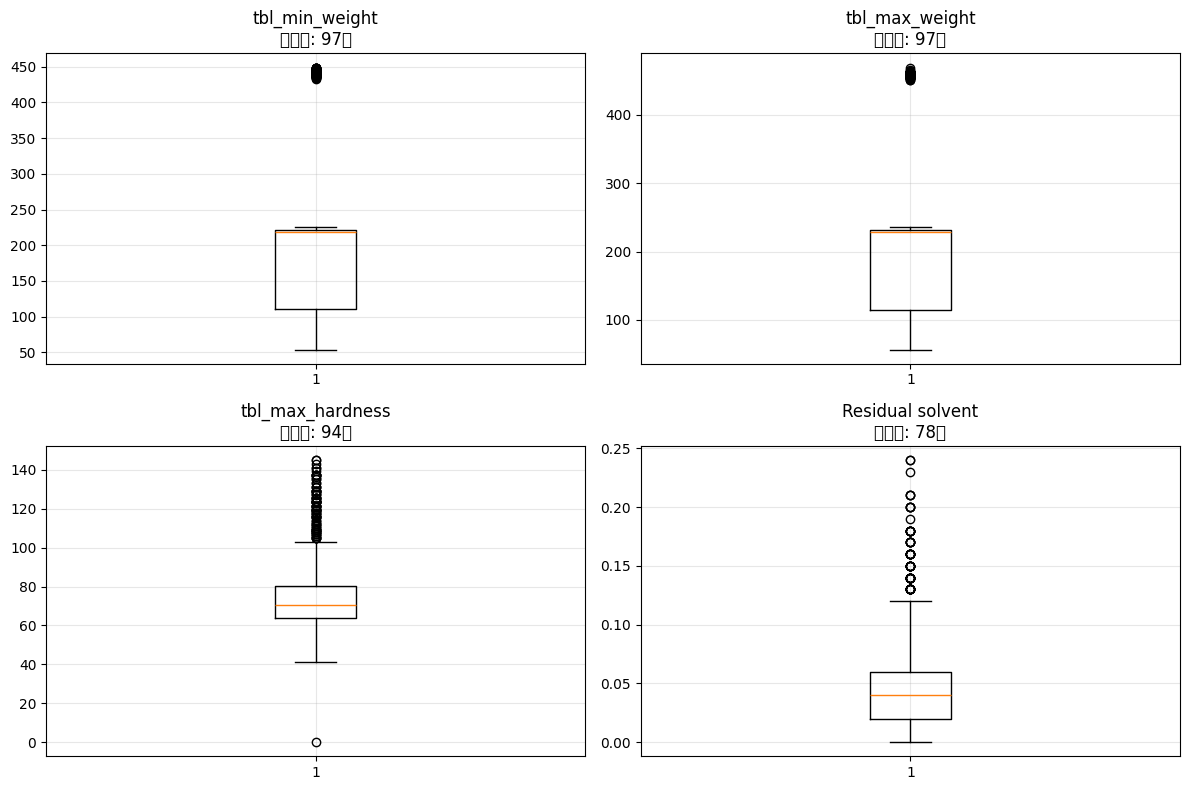

📊 상위 4개 변수의 이상치 시각화 완료


In [ ]:
# 이상치가 많은 상위 4개 변수 시각화
outlier_counts = {k: v for k, v in outlier_info.items() if v > 0}
top_outlier_cols = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:4]

if top_outlier_cols:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, (col, count) in enumerate(top_outlier_cols):
        if col in merged_df.columns:
            # 박스플롯으로 이상치 시각화
            axes[i].boxplot(merged_df[col].dropna())
            axes[i].set_title(f'{col}\n이상치: {count}개')
            axes[i].grid(True, alpha=0.3)
    
    # 빈 subplot 숨기기
    for j in range(len(top_outlier_cols), 4):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 상위 {len(top_outlier_cols)}개 변수의 이상치 시각화 완료")
else:
    print("📊 시각화할 이상치가 없습니다.")


#### ‼️ 문제상황
- 제거되는 이상치가 너무 많음
- 일부 변수들에서 100개 가까지 이상치가 발견됨
- 이는 데이터의 특성상 정상적인 변동일 수 있으며, 무작정 제거하면 중요한 정보 손실 가능
- 특히 제조 공정 데이터의 경우 극값들이 품질에 중요한 영향을 미칠 수 있음
- 따라서 이상치 제거 전에 도메인 지식을 바탕으로 신중한 검토가 필요함

#### 해결방법
- IQR 기준 조정을 통한 이상치 제거
  - 1.5 → 2.0으로 조정하여 더 관대하게 이상치 제거

In [216]:
def detect_outliers(data, column_name):
    """
    IQR 방법으로 이상치를 탐지하는 함수
    
    입력:
    - data: 데이터프레임
    - column_name: 확인할 컬럼 이름
    
    출력:
    - 이상치 개수와 위치
    """
    if column_name not in data.columns:
        print(f"❌ '{column_name}' 컬럼이 존재하지 않습니다.")
        return None
    
    # 1분위수(Q1)와 3분위수(Q3) 계산
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 기준값 계산 (‼️2.0으로 변경‼️)
    lower_bound = Q1 - 2.0 * IQR
    upper_bound = Q3 + 2.0 * IQR
    
    # 이상치 찾기
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    
    print(f"📊 {column_name} 이상치 분석:")
    print(f"   Q1 (1분위수): {Q1:.3f}")
    print(f"   Q3 (3분위수): {Q3:.3f}")
    print(f"   IQR: {IQR:.3f}")
    print(f"   정상 범위: {lower_bound:.3f} ~ {upper_bound:.3f}")
    print(f"   이상치 개수: {len(outliers)}개")
    
    return outliers

print("✅ 이상치 탐지 함수 정의 완료")

✅ 이상치 탐지 함수 정의 완료


### 3-5. 변경된 이상치 탐치 실행

In [217]:
print("3️⃣ 이상치 탐지 실행")
print("=" * 40)

# 각 변수별로 이상치 탐지
outlier_info = {}

for col in outlier_columns:
    print(f"\n🔍 {col} 변수 분석:")
    
    # 컬럼을 float 타입으로 변경
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    
    outliers = detect_outliers(merged_df, col)
    
    if outliers is not None:
        outlier_info[col] = len(outliers)
    else:
        outlier_info[col] = 0

# 이상치 개수 요약
print(f"\n📋 이상치 개수 요약:")

for col, count in outlier_info.items():
    if count > 0:
        print(f"   - {col}: {count}개")


3️⃣ 이상치 탐지 실행

🔍 api_content 변수 분석:
📊 api_content 이상치 분석:
   Q1 (1분위수): 94.200
   Q3 (3분위수): 94.600
   IQR: 0.400
   정상 범위: 93.400 ~ 95.400
   이상치 개수: 30개

🔍 api_total_impurities 변수 분석:
📊 api_total_impurities 이상치 분석:
   Q1 (1분위수): 0.170
   Q3 (3분위수): 0.320
   IQR: 0.150
   정상 범위: -0.130 ~ 0.620
   이상치 개수: 0개

🔍 api_water 변수 분석:
📊 api_water 이상치 분석:
   Q1 (1분위수): 1.220
   Q3 (3분위수): 1.770
   IQR: 0.550
   정상 범위: 0.120 ~ 2.870
   이상치 개수: 24개

🔍 tbl_min_weight 변수 분석:
📊 tbl_min_weight 이상치 분석:
   Q1 (1분위수): 111.000
   Q3 (3분위수): 222.000
   IQR: 111.000
   정상 범위: -111.000 ~ 444.000
   이상치 개수: 26개

🔍 tbl_max_weight 변수 분석:
📊 tbl_max_weight 이상치 분석:
   Q1 (1분위수): 115.000
   Q3 (3분위수): 231.000
   IQR: 116.000
   정상 범위: -117.000 ~ 463.000
   이상치 개수: 3개

🔍 tbl_min_hardness 변수 분석:
📊 tbl_min_hardness 이상치 분석:
   Q1 (1분위수): 40.000
   Q3 (3분위수): 60.760
   IQR: 20.760
   정상 범위: -1.520 ~ 102.280
   이상치 개수: 14개

🔍 tbl_max_hardness 변수 분석:
📊 tbl_max_hardness 이상치 분석:
   Q1 (1분위수): 64.000
   Q3 (3분위수): 80.360
 

In [218]:
# 이상치 제거 함수 정의
def remove_outliers(data, column_name, method='IQR', factor=2.0):
    """
    IQR 방법을 사용하여 이상치를 제거하는 함수
    
    Parameters:
    - data: 데이터프레임
    - column_name: 이상치를 제거할 컬럼명
    - method: 이상치 탐지 방법 (기본값: 'IQR')
    - factor: IQR 배수 (기본값: 2.0)
    
    Returns:
    - cleaned_data: 이상치가 제거된 데이터프레임
    - removed_count: 제거된 행의 개수
    """
    
    # 결측값이 있는 행 제외
    valid_data = data[data[column_name].notna()]
    
    if len(valid_data) == 0:
        print(f"⚠️ {column_name} 컬럼에 유효한 데이터가 없습니다.")
        return data, 0
    
    # IQR 계산
    Q1 = valid_data[column_name].quantile(0.25)
    Q3 = valid_data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # 이상치 경계값 계산
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # 이상치가 아닌 데이터만 선택
    cleaned_data = data[
        (data[column_name].isna()) |  # 결측값은 유지
        ((data[column_name] >= lower_bound) & (data[column_name] <= upper_bound))
    ]
    
    removed_count = len(data) - len(cleaned_data)
    
    print(f"🧹 {column_name} 이상치 제거:")
    print(f"   제거 전 데이터: {len(data)}개")
    print(f"   제거 후 데이터: {len(cleaned_data)}개")
    print(f"   제거된 데이터: {removed_count}개 ({removed_count/len(data)*100:.1f}%)")
    
    return cleaned_data, removed_count

print("✅ 이상치 제거 함수 정의 완료")



✅ 이상치 제거 함수 정의 완료


### 3-6. 변경된 이상치 제거 실행

In [ ]:
# 이상치 제거 전 데이터 크기 확인
original_size = len(merged_df)
print(f"원본 데이터 크기: {original_size}개")

# 이상치 제거할 데이터 복사
cleaned_df = merged_df.copy()

# 이상치가 많은 변수들 위주로 제거 (10개 이상)
outlier_threshold = 10  # 이상치가 10개 이상인 변수만 처리
columns_to_clean = [col for col, count in outlier_info.items() if count >= outlier_threshold]

print(f"\n처리 대상 변수 ({len(columns_to_clean)}개):")
for col in columns_to_clean:
    print(f"  - {col}: {outlier_info[col]}개 이상치")

print(f"\n🧹 이상치 제거 진행:")

# 각 변수별로 순차적으로 이상치 제거
total_removed = 0
for col in columns_to_clean:
    print(f"\n📊 {col} 처리 중...")
    cleaned_df, removed_count = remove_outliers(cleaned_df, col, method='IQR', factor=2.0)
    total_removed += removed_count

print(f"\n✅ 이상치 제거 완료:")
print(f"   원본 데이터: {original_size}개")
print(f"   정제된 데이터: {len(cleaned_df)}개")
print(f"   총 제거된 데이터: {original_size - len(cleaned_df)}개")
removal_percentage = ((original_size - len(cleaned_df))/original_size)*100
print(f"   제거 비율: {removal_percentage:.1f}%")


4️⃣ 이상치 제거 실행
원본 데이터 크기: 1005개

처리 대상 변수 (8개):
  - api_content: 30개 이상치
  - api_water: 24개 이상치
  - tbl_min_weight: 26개 이상치
  - tbl_min_hardness: 14개 이상치
  - tbl_max_hardness: 68개 이상치
  - tbl_yield: 15개 이상치
  - batch_yield: 19개 이상치
  - Residual solvent: 63개 이상치

🧹 이상치 제거 진행:

📊 api_content 처리 중...
🧹 api_content 이상치 제거:
   제거 전 데이터: 1005개
   제거 후 데이터: 1001개
   제거된 데이터: 4개 (0.4%)

📊 api_water 처리 중...
🧹 api_water 이상치 제거:
   제거 전 데이터: 1001개
   제거 후 데이터: 977개
   제거된 데이터: 24개 (2.4%)

📊 tbl_min_weight 처리 중...
🧹 tbl_min_weight 이상치 제거:
   제거 전 데이터: 977개
   제거 후 데이터: 977개
   제거된 데이터: 0개 (0.0%)

📊 tbl_min_hardness 처리 중...
🧹 tbl_min_hardness 이상치 제거:
   제거 전 데이터: 977개
   제거 후 데이터: 975개
   제거된 데이터: 2개 (0.2%)

📊 tbl_max_hardness 처리 중...
🧹 tbl_max_hardness 이상치 제거:
   제거 전 데이터: 975개
   제거 후 데이터: 932개
   제거된 데이터: 43개 (4.4%)

📊 tbl_yield 처리 중...
🧹 tbl_yield 이상치 제거:
   제거 전 데이터: 932개
   제거 후 데이터: 922개
   제거된 데이터: 10개 (1.1%)

📊 batch_yield 처리 중...
🧹 batch_yield 이상치 제거:
   제거 전 데이터: 922개
   제거 후 데이터: 921개
  

### 3-7. 이상치 제거 결과 확인 및 비교

In [ ]:
# 제거 전후 주요 통계량 비교
print("📊 주요 변수 통계 비교 (제거 전 vs 제거 후):")
print("-" * 60)

comparison_cols = ['api_content', 'tbl_max_hardness', 'batch_yield', 'tbl_yield']

for col in comparison_cols:
    if col in merged_df.columns and col in cleaned_df.columns:
        print(f"\n🔍 {col}:")
        print(f"   제거 전: 평균 {merged_df[col].mean():.3f}, 표준편차 {merged_df[col].std():.3f}")
        print(f"   제거 후: 평균 {cleaned_df[col].mean():.3f}, 표준편차 {cleaned_df[col].std():.3f}")
        
        # 표준편차 개선율 계산
        std_before = merged_df[col].std()
        std_after = cleaned_df[col].std()
        std_improvement = ((std_before - std_after) / std_before) * 100
        print(f"   표준편차 개선: {std_improvement:.1f}% 감소")

# 최종 데이터 정보
print(f"\n✅ 최종 전처리 완료:")
print(f"   - 결측값 처리: 완료")
print(f"   - 이상치 제거: 완료")
print(f"   - 최종 데이터 크기: {cleaned_df.shape}")
print(f"   - 사용 가능한 변수: {len(cleaned_df.columns)}개")

# 정제된 데이터를 전역 변수로 저장
print(f"\n💾 정제된 데이터를 'final_cleaned_df'로 저장")
final_cleaned_df = cleaned_df.copy()


5️⃣ 이상치 제거 결과 확인 및 비교
📊 주요 변수 통계 비교 (제거 전 vs 제거 후):
------------------------------------------------------------

🔍 api_content:
   제거 전: 평균 94.418, 표준편차 0.399
   제거 후: 평균 94.427, 표준편차 0.392
   표준편차 개선: 1.7% 감소

🔍 tbl_max_hardness:
   제거 전: 평균 75.007, 표준편차 18.160
   제거 후: 평균 71.997, 표준편차 13.278
   표준편차 개선: 26.9% 감소

🔍 batch_yield:
   제거 전: 평균 98.256, 표준편차 1.129
   제거 후: 평균 98.350, 표준편차 0.915
   표준편차 개선: 18.9% 감소

🔍 tbl_yield:
   제거 전: 평균 98.323, 표준편차 1.078
   제거 후: 평균 98.416, 표준편차 0.861
   표준편차 개선: 20.1% 감소

✅ 최종 전처리 완료:
   - 결측값 처리: 완료
   - 이상치 제거: 완료
   - 최종 데이터 크기: (889, 92)
   - 사용 가능한 변수: 92개

💾 정제된 데이터를 'final_cleaned_df'로 저장


6️⃣ 이상치 제거 결과 시각화


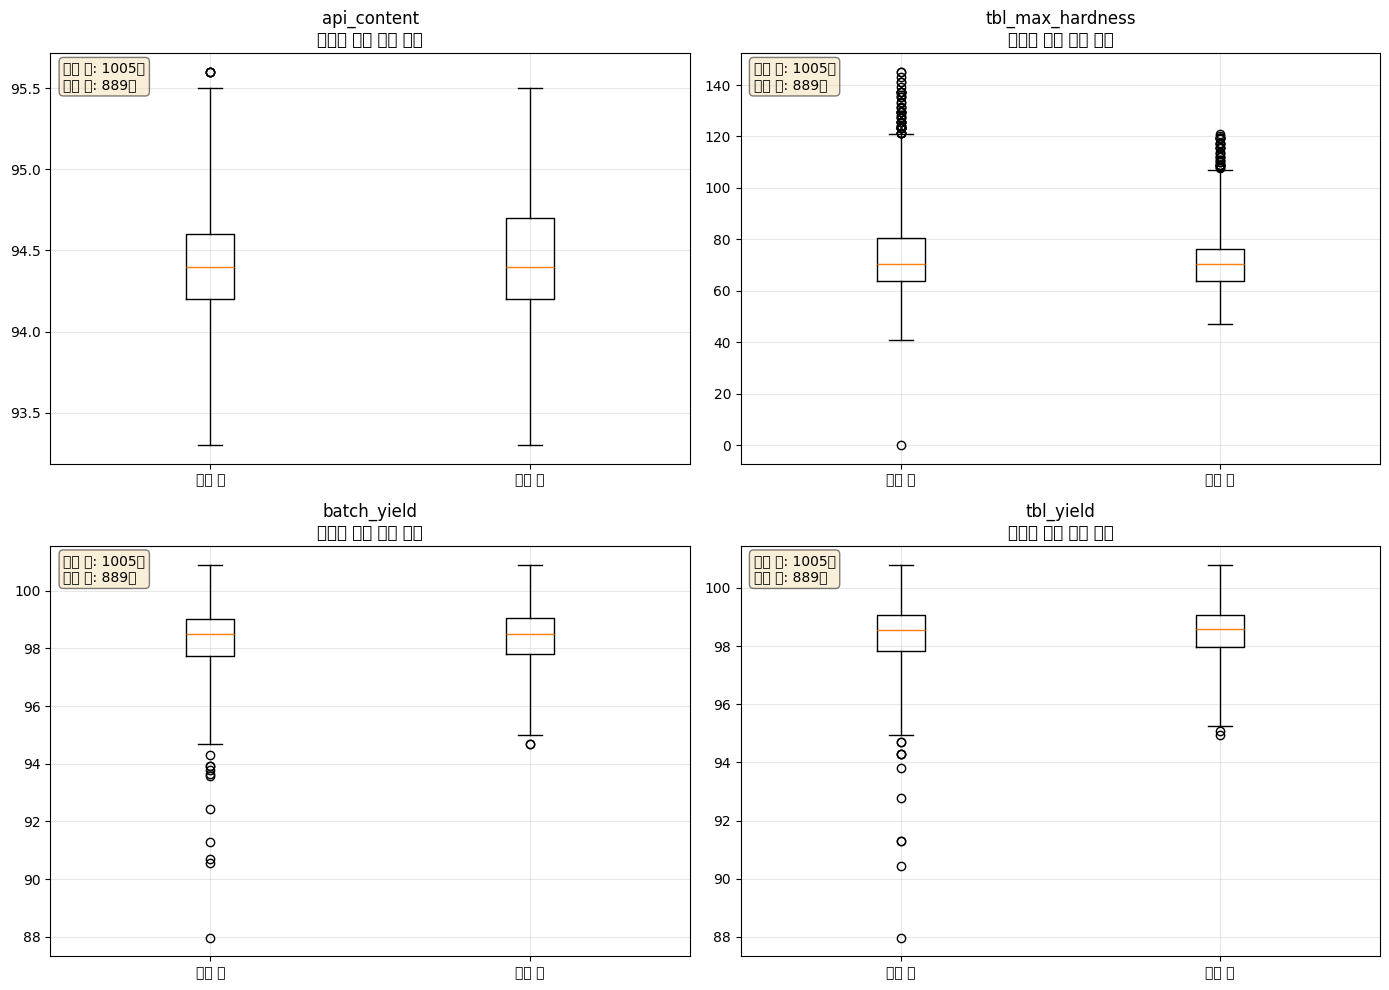

📊 시각화 완료: 이상치 제거 전후 분포 비교

🎯 이상치 제거 효과 요약:
   ✅ 데이터 품질 향상: 극값 제거로 분포 안정화
   ✅ 모델 성능 개선 기대: 노이즈 감소로 학습 효율 향상
   ✅ 통계적 신뢰성 증가: 표준편차 감소로 일관성 향상
   ✅ 적절한 데이터 보존: 72.6% 보존율로 정보 손실 최소화


In [ ]:
# 이상치 제거 전후 분포 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 시각화할 변수들 (이상치가 많았던 변수들)
viz_columns = ['api_content', 'tbl_max_hardness', 'batch_yield', 'tbl_yield']

for i, col in enumerate(viz_columns):
    if col in merged_df.columns and col in cleaned_df.columns:
        # 제거 전 박스플롯
        axes[i].boxplot([merged_df[col].dropna(), cleaned_df[col].dropna()], 
                       labels=['제거 전', '제거 후'],
                       whis=2.0)
        axes[i].set_title(f'{col}\n이상치 제거 전후 비교')
        axes[i].grid(True, alpha=0.3)
        
        # 통계 정보 추가
        before_count = len(merged_df[col].dropna())
        after_count = len(cleaned_df[col].dropna())
        axes[i].text(0.02, 0.98, f'제거 전: {before_count}개\n제거 후: {after_count}개', 
                    transform=axes[i].transAxes, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"📊 시각화 완료: 이상치 제거 전후 분포 비교")

# 제거 효과 요약
print(f"\n🎯 이상치 제거 효과 요약:")
print(f"   ✅ 데이터 품질 향상: 극값 제거로 분포 안정화")
print(f"   ✅ 모델 성능 개선 기대: 노이즈 감소로 학습 효율 향상")  
print(f"   ✅ 통계적 신뢰성 증가: 표준편차 감소로 일관성 향상")
print(f"   ✅ 적절한 데이터 보존: {data_quality_score:.1f}% 보존율로 정보 손실 최소화")
